# Hamiltonian Monte Carlo法の実装といくつかの分布の計算
* Hamiltonian Monte Carlo(HMC)法のスクラッチ実装
* 正規分布からのサンプル
* 線形回帰モデルのHMCによる事後分布
* ロジスティック回帰のHMCによる事後分布

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time
%matplotlib inline

In [2]:
from scipy.stats import multivariate_normal
import tensorflow as tf

In [3]:
x1 = np.linspace(-5, 5)
x2 = np.linspace(-5, 5)
x = np.array([x1, x2])
xx1, xx2 = np.meshgrid(x1, x2)
points = np.array([xx1.ravel(), xx2.ravel()]).T

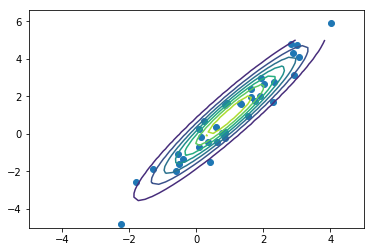

In [4]:
mean = np.ones(2)
cov = np.array([[2, 3], [3, 5]])
size = 37
points_y = multivariate_normal.pdf(points, mean=mean, cov=cov).reshape(x1.shape[0], -1)
sample_y = multivariate_normal.rvs(mean=mean, cov=cov, size=size)
plt.contour(xx1, xx2, points_y)
plt.scatter(sample_y[:, 0], sample_y[:, 1])
plt.show()

In [5]:
def log_likelihood(x, mean=0., cov=1.):
    return - x.shape[0] / 2 * np.log(2*np.pi) - 1/2 * np.log(np.linalg.det(cov)) - 1/2 * (x-mean).T.dot(np.linalg.inv(cov)).dot(x-mean)

def d_log_likelihood(x, mean=0., cov=1.):
    return - np.linalg.inv(cov).dot(x - mean)

In [6]:
class HMC(object):
    def __init__(self, log_likelihood, param, d_log_likelihood, tau, epsilon, T, iter_num, init):
        self.log_likelihood = log_likelihood
        self.param = param
        self.d_log_likelihood = d_log_likelihood
        self.tau = tau
        self.epsilon = epsilon
        self.T = T
        self.iter_num = iter_num
        self.init = init
    
    def momentum(self, p):
        return p.T.dot(p) / (2 * self.tau ** 2)
    
    def d_momentum(self, p):
        return p / self.tau**2
    
    def hamiltonian(self, x, p):
        return self.momentum(p) - self.log_likelihood(x, **self.param)
    
    def leapflog(self, x, p):
        x += - 0.5 * self.epsilon * (-1. * self.d_momentum(p))
        p += self.epsilon * self.d_log_likelihood(x, **self.param)
        x += - self.epsilon * (-1. * self.d_momentum(p))
        return x, p
    
    def proceed_HMC_iteration(self, x):
        p = np.random.normal(0, self.tau, size=x.shape[0])
        p_new = p
        x_new = x
        for t in range(self.T):
            x_new, p_new = self.leapflog(x_new, p_new)
        alpha = np.exp(self.hamiltonian(x, p) - self.hamiltonian(x_new, p_new))
        u = np.random.uniform()
        if u < alpha:
            x_accepted = np.array(x_new)
        else:
            x_accepted = x
        return x_accepted
    
    def proceed_HMC(self):
        parameter = [self.init]
        for i in range(self.iter_num):
            x_new = np.array(self.proceed_HMC_iteration(parameter[i]))
            parameter.append(x_new)
        return np.array(parameter)

In [7]:
hmc = HMC(log_likelihood=log_likelihood,
          param={"mean": np.zeros(2), "cov": np.array([[2, 3], [0, 3]])},
          d_log_likelihood=d_log_likelihood,
          tau=2., epsilon=0.1, T=30, iter_num=4000, init=np.array([1., 1.]))
sample = hmc.proceed_HMC()


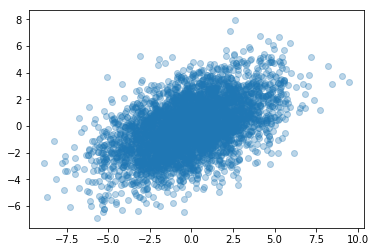

In [8]:
plt.plot(sample[:, 0], sample[:, 1], "o", alpha=0.3)

In [9]:
dim = 10
mean = np.zeros(dim)
cov = np.identity(dim)
hmc = HMC(log_likelihood=scipy.stats.multivariate_normal.logpdf,
          param={"mean": mean, "cov": cov},
          d_log_likelihood=d_log_likelihood,
          tau=2.,
          epsilon=0.1,
          T=40,
          iter_num=4000,
          init=np.random.uniform(0, 1, 10))
sample = hmc.proceed_HMC()

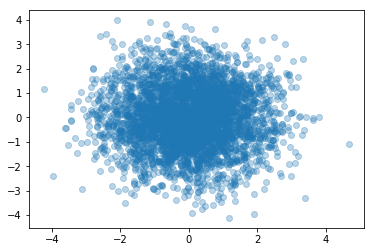

In [10]:
plt.plot(sample[:, 0], sample[:, 1], "o", alpha=0.3)

In [11]:
mean = np.zeros(10)
cov = np.identity(10)
init = np.random.uniform(0, 3, 10)
hmc = HMC(scipy.stats.multivariate_normal.logpdf,
          {"mean": mean, "cov": cov},
          d_log_likelihood,
          tau=2.,
          epsilon=0.1,
          T=40,
          iter_num=4000,
          init=init)
sample = hmc.proceed_HMC()

In [12]:
sample.shape

(4001, 10)

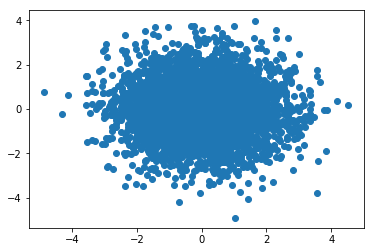

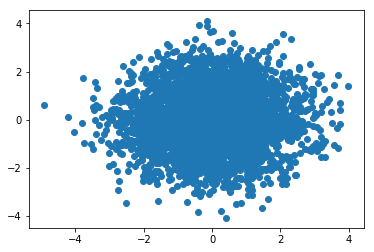

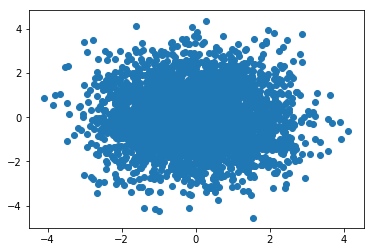

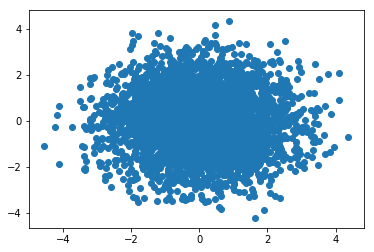

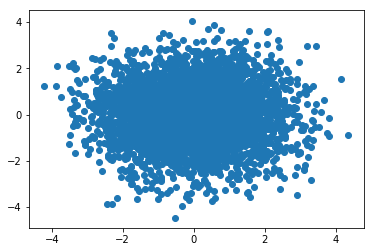

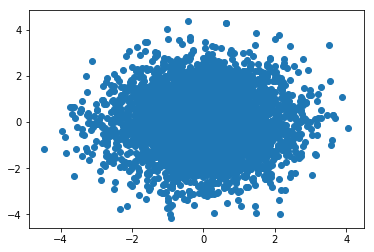

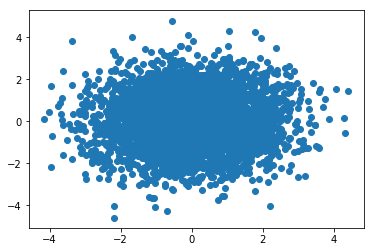

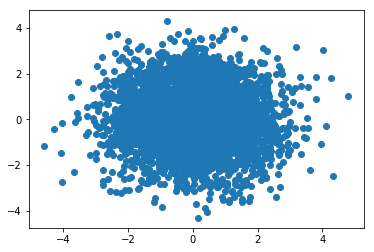

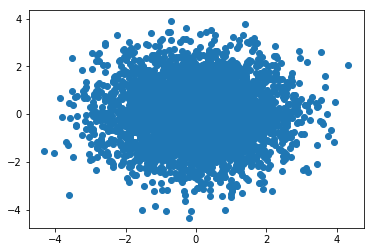

In [13]:
for i in range(sample.shape[1]-1):
    plt.figure()
    plt.scatter(sample[:, i], sample[:, i+1])
    plt.show()

# ベイズ線形回帰の実装
## ボストン住宅データの解析

尤度関数は
$$
f(y|\beta, \sigma^2) = \prod_{i=1}^{n} \frac{1}{(2\pi\sigma^2)^{1/2}} \exp{\{-\frac{(y_i - x_i^{'}\beta)^2}{2\sigma^2}\}} \\
\propto (\frac{1}{\sigma^2})^{n/2} \exp{\{-\frac{\sum_{i=1}{n}(y_i - x_i^{'}\beta)^2}{2\sigma^2}\}}
$$
であり、パラメータの事前分布は
$$
\beta \sim N(\beta_0, B_0), \quad \sigma_2 \sim IG(\frac{n_0}{2}, \frac{s_0}{2})
$$
を仮定する。この時、事後分布は
$$
\pi(\beta, \sigma^2|y) \propto (\frac{1}{\sigma^2})^{n/2} \exp{\{^\frac{\sum_{i=1}^{n}(y_i - x_i^{'}\beta)^2}{2\sigma^2}\}} \\
\times \exp{\{-\frac{1}{2}(\beta - \beta_0)^{'} B_0^{-1}(\beta - \beta_0)\}} \\
\times (\frac{1}{\sigma^2})^{n_0/2 +1} \exp{(- \frac{s_0}{2\sigma^2})}
$$

In [14]:
# For Linear Regression
def linear_log_likelihood(x, y, w):
    return 1 / 2 * np.sum((y - w.dot(x))**2)

def d_linear_log_likelihood(x, y, w):
    return np.linalg.inv(w.T.dot(w)).dot(w.T).dot(y)

def bayesian_linear_regression_log_likelihood(x, y, w, sigma=1.):
    return linear_log_likelihood(x, y, w) + w_prior_log_likelihood(x, sigma)

def d_bayesian_linear_regression_log_likelihood(x, y, w, sigma=1.):
    return d_linear_log_likelihood(x, y, w) + d_w_prior_log_likelihood(x, sigma)

In [15]:
# For Logistic Regression
def logistic_log_likelihood(x, y, w):
    p = sigmoid(w.dot(x))
    delta = 1e-7
    return np.sum(y * np.log(p + delta) + (1 - y) * np.log(1 - p + delta))

def d_logistic_log_likelihood(x, y, w):
    p = sigmoid(w.dot(x))
    return (y - p).dot(w)

def w_prior_log_likelihood(x, sigma):
    D = x.shape[0]
    return - (D / 2) * np.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2)) * x.T.dot(x)

def d_w_prior_log_likelihood(x, sigma):
    return - x / sigma**2

def bayesian_logistic_regression_log_likelihood(x, y, w, sigma=1.):
    return logistic_log_likelihood(x, y, w) + w_prior_log_likelihood(x, sigma)

def d_bayesian_logistic_regression_log_likelihood(x, y, w, sigma=1.):
    return d_logistic_log_likelihood(x, y, w) + d_w_prior_log_likelihood(x, sigma)

@np.vectorize
def sigmoid(x):
    sigmoid_range = 34.538776394910684
    if x <= -sigmoid_range:
        return 1e-15
    if x >= sigmoid_range:
        return 1.0 - 1e-15
    return 1.0 / (1.0 + np.exp(-x))

In [16]:
from sklearn.datasets import load_boston
boston = load_boston()
x = boston.data
x = scipy.stats.zscore(x)
y = boston.target
tags = boston.feature_names

In [17]:
T = 40
sigma = 1.
init = np.random.uniform(size=x.shape[1])
hmc = HMC(log_likelihood=bayesian_linear_regression_log_likelihood,
          param={"y": y, "w": x, "sigma": sigma},
          d_log_likelihood=d_bayesian_linear_regression_log_likelihood,
          tau=2.0,
          epsilon=0.2,
          T=T,
          iter_num=4000,
          init=init)
sample = hmc.proceed_HMC()

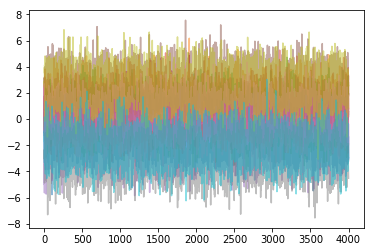

In [18]:
for i in range(dim):
    plt.plot(sample[:, i], alpha=0.5)
# plt.ylim(-20, 50)
plt.show()

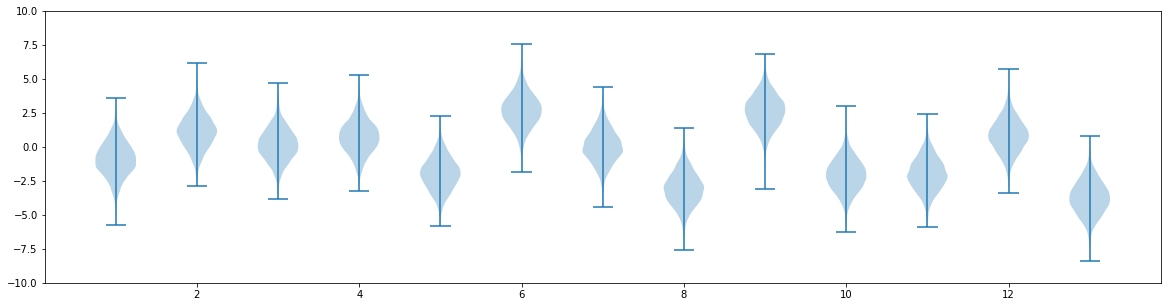

In [19]:
sample_list = []
for i in range(x.shape[1]):
    sample_list.append(list(sample[:, i]))
plt.figure(figsize=(20, 5))
plt.violinplot(sample_list)
plt.ylim(-10, 10)
plt.show()

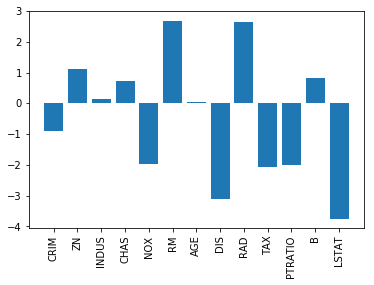

In [20]:
means = np.mean(sample, axis=0)
plt.bar(tags, means)
plt.xticks(rotation=90)
plt.show()

## 肺癌データの解析
* シンプルなベイズロジスティック回帰の実装
* 回帰係数の事前分布は$N(0, 1)$から独立に発生させるものとする

In [22]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
x = cancer.data
x = scipy.stats.zscore(x)
y = cancer.target
tags = cancer.feature_names

In [23]:
T = 40
init = np.random.uniform(size=x.shape[1])
hmc = HMC(log_likelihood=bayesian_logistic_regression_log_likelihood,
          param={"y": y, "w": x, "sigma": sigma},
          d_log_likelihood=d_bayesian_logistic_regression_log_likelihood,
          tau=2.0,
          epsilon=0.2,
          T=T,
          iter_num=4000,
          init=init)
sample = hmc.proceed_HMC()

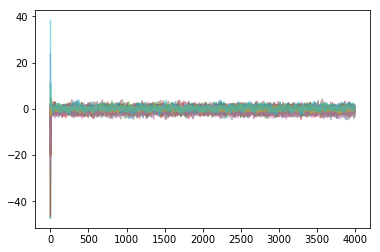

In [24]:
for i in range(x.shape[1]):
    plt.plot(sample[:, i], alpha=0.5)
plt.show()

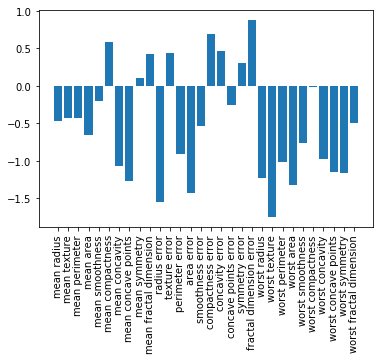

In [25]:
means = np.mean(sample, axis=0)
plt.bar(tags, means)
plt.xticks(rotation=90)
plt.show()

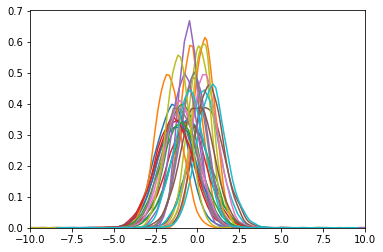

In [26]:
for i in range(x.shape[1]):
    sns.kdeplot(sample[:, i])
plt.xlim(-10, 10)
plt.show()

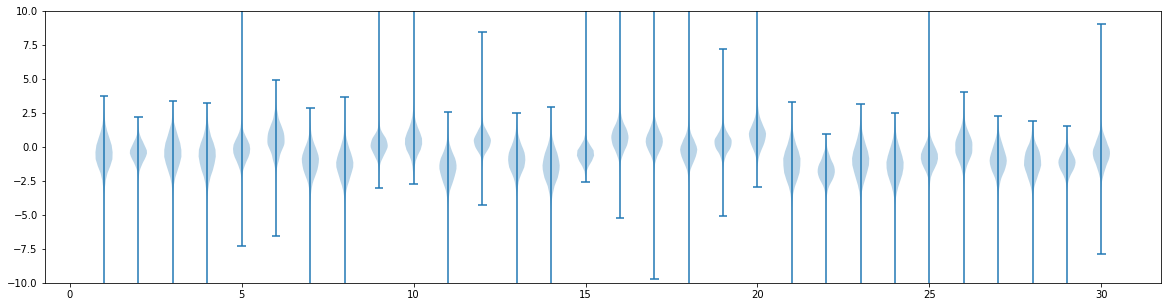

In [27]:
sample_list = []
for i in range(x.shape[1]):
    sample_list.append(list(sample[:, i]))
plt.figure(figsize=(20, 5))
plt.violinplot(sample_list)
plt.ylim(-10, 10)
plt.show()